In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import StringIO
from matplotlib import pyplot as plt
import datetime, time
import os
import json
import requests
# from bs4 import BeautifulSoup
from pprint import pprint
import pytrends as pt
from pytrends.request import TrendReq

% matplotlib inline

In [10]:
def getJSON(url):
    start_time = time.time()
    header = {'x-requested-with': 'XMLHttpRequest'}
    mainPage = requests.get(url, headers = header)
    data = mainPage.json()
    print('Query finished in ' + str(time.time() - start_time))
    return data

In [11]:
#get CMC Symbol Info from API
try:
    data = getJSON("https://api.coinmarketcap.com/v1/ticker/")
except ValueError:
    print "CMC API Not Responding"

#write to dictionary
token_dict = {}

for x in range (0,50):
    token_dict[data[x]['symbol']] = data[x]['name']


print token_dict

Query finished in 0.190631151199
{u'NEO': u'NEO', u'BCN': u'Bytecoin', u'KMD': u'Komodo', u'BCH': u'Bitcoin Cash', u'GNT': u'Golem', u'STEEM': u'Steem', u'PAY': u'TenX', u'REP': u'Augur', u'XLM': u'Stellar Lumens', u'BAT': u'Basic Attention Token', u'BCC': u'BitConnect', u'EOS': u'EOS', u'ETC': u'Ethereum Classic', u'GAME': u'GameCredits', u'ETH': u'Ethereum', u'GNO': u'Gnosis', u'DGB': u'DigiByte', u'FCT': u'Factom', u'DGD': u'DigixDAO', u'QTUM': u'Qtum', u'STRAT': u'Stratis', u'LSK': u'Lisk', u'HSR': u'Hshare', u'PPT': u'Populous', u'DCR': u'Decred', u'GBYTE': u'Byteball', u'ICN': u'Iconomi', u'NXS': u'Nexus', u'ZEC': u'Zcash', u'DASH': u'Dash', u'MCAP': u'MCAP', u'MIOTA': u'IOTA', u'MTL': u'Metal', u'VERI': u'Veritaseum', u'USDT': u'Tether', u'XRP': u'Ripple', u'XMR': u'Monero', u'BTCD': u'BitcoinDark', u'LTC': u'Litecoin', u'OMG': u'OmiseGO', u'BTS': u'BitShares', u'XEM': u'NEM', u'DOGE': u'Dogecoin', u'PIVX': u'PIVX', u'SYS': u'Syscoin', u'MAID': u'MaidSafeCoin', u'BTC': u'Bitcoin

In [12]:
token_dict['XRP']='XRP'


In [13]:
token1 = 'LTC'
token2 = 'BTC'

#Get Historical Price Data
search_url = 'https://min-api.cryptocompare.com/data/histoday?fsym='+token1+'&tsym='+token2+'&limit=2000&aggregate=1&e=CCCAGG'
result = getJSON(search_url)

Query finished in 1.43336701393


In [14]:
def get_price_data(token1, token2):
    search_url = 'https://min-api.cryptocompare.com/data/histoday?fsym='+token1+'&tsym='+token2+'&limit=2000&aggregate=1&e=CCCAGG'
    result = getJSON(search_url)
    price_data = pd.DataFrame(result['Data'])
    price_data['date'] = pd.to_datetime(price_data['time'],unit='s')
    price_data = price_data.set_index('date')
    return(price_data['close'])

def get_index_data(token1, token2):
    pytrend.build_payload([token_dict[token1],token_dict[token2]], cat=0, timeframe='today 5-y', geo='', gprop='')
    google_index_data = pytrend.interest_over_time()
    google_index_data['index_exchange'] = google_index_data[token_dict[token1]]/google_index_data[token_dict[token2]]
    return(google_index_data['index_exchange'])

In [15]:
get_price_data(token1,token2).tail()

Query finished in 0.86176609993


date
2017-09-04    0.01582
2017-09-05    0.01671
2017-09-06    0.01766
2017-09-07    0.01736
2017-09-08    0.01668
Name: close, dtype: float64

In [16]:
price_data = pd.DataFrame(result['Data'])
price_data['date'] = pd.to_datetime(price_data['time'],unit='s')
price_data = price_data.set_index('date')

In [17]:
(price_data[price_data.close>0]).index.min()

Timestamp('2013-09-29 00:00:00')

In [18]:
pytrend = TrendReq()
pytrend.build_payload([token_dict[token1],token_dict[token2]], cat=0, timeframe='today 5-y', geo='', gprop='')
google_index_data = pytrend.interest_over_time()

# pytrend.build_payload([token_dict[token1],token_dict[token2]], cat=0, timeframe='now 7-d', geo='', gprop='')
# google_index_data_extend = pytrend.interest_over_time()

# google_index_data = google_index_data.append(google_index_data_extend)

In [19]:
# truncate data
date_start = datetime.datetime(2017,1,1)
date_start = max((price_data[price_data.close>0]).index.min(),date_start)
price_data_trunc = price_data[price_data.index>=date_start]
google_index_data_trunc = (google_index_data[google_index_data.index>=date_start]).copy()
google_index_data_trunc['index_exchange'] = google_index_data_trunc[token_dict[token1]]/google_index_data_trunc[token_dict[token2]]

In [20]:
google_index_adjustment_rate = price_data_trunc['close'].mean()/google_index_data_trunc['index_exchange'].mean()

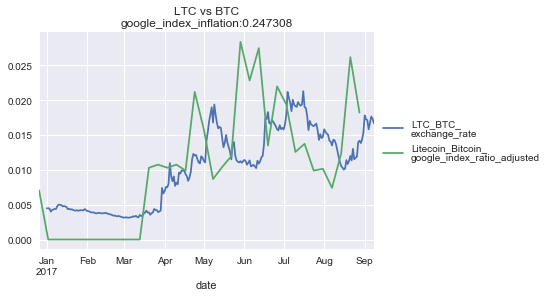

In [21]:
(price_data_trunc['close']).plot(label=token1+'_'+token2+'_\nexchange_rate')
(google_index_data_trunc['index_exchange']*google_index_adjustment_rate).plot(label=token_dict[token1]+'_'+token_dict[token2]+'_\ngoogle_index_ratio_adjusted')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(token1+' vs '+token2+'\ngoogle_index_inflation:'+str(round(google_index_adjustment_rate,6)))
# plt.annotate()

In [22]:
price_back_testing = price_data_trunc['close']
gindex_back_testing = google_index_data_trunc['index_exchange']

In [24]:
index_change_trigger = 1.5

# just correlation code
shift_period_in_days = -7
shift_data = pd.concat([price_back_testing.shift(shift_period_in_days),gindex_back_testing],axis=1).dropna()
correlation = shift_data.corr().iloc[1,0]

# back testing code
index_change = gindex_back_testing/gindex_back_testing.shift(1)
buy_points = index_change[index_change>=index_change_trigger]
buy_price = price_back_testing[price_back_testing.index.isin(buy_points.index)]

buy_return_data = pd.DataFrame(columns=buy_points.index,index=price_back_testing.index)
for (i,j) in buy_price.iteritems():
    buy_return_data[i] = price_back_testing[price_back_testing.index>=i]/j

trading_performance  = pd.DataFrame(index=buy_points.index, columns=['buy_price','sell_point','sell_price'])
sell_threshold_upper = 1.2
sell_threshold_lower = 0.85

for trade_series in buy_return_data.columns:
    buy_series = buy_return_data[trade_series]
    sell_point = min(pd.Series([buy_series[buy_series>=sell_threshold_upper].index.min(),buy_series[buy_series<=sell_threshold_lower].index.min(),price_back_testing.index.max()]).dropna())
    sell_price = price_back_testing[sell_point]
    trading_performance.loc[trade_series,'buy_price'] = price_back_testing[trade_series]
    trading_performance.loc[trade_series,'sell_point'] = sell_point
    trading_performance.loc[trade_series,'sell_price'] = sell_price

In [25]:
price_back_testing[price_back_testing.index.isin(buy_points.index)]

date
2017-03-26    0.004236
2017-04-30    0.011730
2017-06-04    0.011020
2017-07-02    0.016530
2017-08-20    0.011270
2017-08-27    0.013960
Name: close, dtype: float64

In [26]:
trading_performance['sell_price']/trading_performance['buy_price']

date
2017-03-26     1.7474
2017-04-30    1.20887
2017-06-04    1.24319
2017-07-02    1.28191
2017-08-20    1.23869
2017-08-27    1.27579
dtype: object

In [419]:
np.array([buy_series[buy_series>=sell_threshold_upper].index.min(),buy_series[buy_series<=sell_threshold_lower].index.min()])

array([Timestamp('2017-09-01 00:00:00'), NaT], dtype=object)

In [420]:
buy_points

date
2017-03-12         inf
2017-03-26         inf
2017-06-04    2.295082
2017-07-02    1.666667
2017-08-20    1.687764
2017-08-27    1.903614
Name: index_exchange, dtype: float64

In [421]:
sell_point

Timestamp('2017-09-01 00:00:00')

In [27]:
trading_performance

,buy_price,sell_point,sell_price
date,,,
2017-03-26,0.004236,2017-03-30 00:00:00,0.007402
2017-04-30,0.01173,2017-05-03 00:00:00,0.01418
2017-06-04,0.01102,2017-06-16 00:00:00,0.0137
2017-07-02,0.01653,2017-07-04 00:00:00,0.02119
2017-08-20,0.01127,2017-08-27 00:00:00,0.01396
2017-08-27,0.01396,2017-09-01 00:00:00,0.01781


In [424]:
trading_performance['sell_price']/trading_performance['buy_price']

date
2017-03-12    1.21557
2017-03-26     1.7474
2017-06-04    1.24319
2017-07-02    1.28191
2017-08-20    1.23869
2017-08-27    1.27579
dtype: object

In [23]:
for trade_series in trading_performance.index:
    buy_price,sell_point,sell_price = trading_performance.loc[trade_series]
    buy_return_data[buy_return_data.index<=sell_point][trade_series].dropna().plot()

NameError: name 'trading_performance' is not defined

In [632]:
import pandas as pd
import numpy as np
import scipy
import datetime

import matplotlib.pyplot as plt

import copy

from jinja2 import Environment, FileSystemLoader



class CryptoBacktesting(object):
    """Class for analyzing crypto_currencies. 

    The idea here is to provide a way to intelligently trade crypto currencies using signals,   

    """
    def __init__(
        self,
        price_back_testing,
        gindex_back_testing,
        index_change_trigger,
        sell_threshold_upper=1.2,
        sell_threshold_lower=0.85,
        
    ):
        """Class constructor

        Args:

        """
        self.price_back_testing = price_back_testing
        self.gindex_back_testing = gindex_back_testing
        self.index_change_trigger = index_change_trigger
        self.sell_threshold_upper = sell_threshold_upper
        self.sell_threshold_lower = sell_threshold_lower

        self.process_back_testing()


    def process_back_testing(self):


        index_change = gindex_back_testing/gindex_back_testing.shift(1)
        buy_points = index_change[index_change>=index_change_trigger]
        buy_price = price_back_testing[price_back_testing.index.isin(buy_points.index)]
        
        self.buy_return_data = pd.DataFrame(columns=buy_points.index,index=price_back_testing.index)
        for (i,j) in buy_price.iteritems():
            self.buy_return_data[i] = price_back_testing[price_back_testing.index>=i]/j
        
        self.trading_performance  = pd.DataFrame(index=buy_points.index, columns=['buy_price','sell_point','sell_price'])
        
        for trade_series in self.buy_return_data.columns:
            buy_series = self.buy_return_data[trade_series]
            sell_point = min(pd.Series([buy_series[buy_series>=sell_threshold_upper].index.min(),buy_series[buy_series<=sell_threshold_lower].index.min(),price_back_testing.index.max()]).dropna())
            sell_price = price_back_testing[sell_point]
            self.trading_performance.loc[trade_series,'buy_price'] = price_back_testing[trade_series]
            self.trading_performance.loc[trade_series,'sell_point'] = sell_point
            self.trading_performance.loc[trade_series,'sell_price'] = sell_price
            self.trading_performance['return'] = self.trading_performance['sell_price']/self.trading_performance['buy_price']
            self.total_return = self.trading_performance['return'].product()
            self.trading_times = self.trading_performance['buy_price'].count()

In [731]:
print token_dict

{u'NEO': u'NEO', u'BCN': u'Bytecoin', u'KMD': u'Komodo', u'BCH': u'Bitcoin Cash', u'GNT': u'Golem', u'STEEM': u'Steem', u'PAY': u'TenX', u'REP': u'Augur', u'XLM': u'Stellar Lumens', u'BAT': u'Basic Attention Token', u'BCC': u'BitConnect', u'EOS': u'EOS', u'ETC': u'Ethereum Classic', u'ETH': u'Ethereum', u'GNO': u'Gnosis', u'DGB': u'DigiByte', u'FCT': u'Factom', u'DGD': u'DigixDAO', u'QTUM': u'Qtum', u'STRAT': u'Stratis', u'LSK': u'Lisk', u'CVC': u'Civic', u'HSR': u'Hshare', u'PPT': u'Populous', u'DCR': u'Decred', u'GBYTE': u'Byteball', u'ICN': u'Iconomi', u'NXS': u'Nexus', u'ZEC': u'Zcash', u'DASH': u'Dash', u'MCAP': u'MCAP', u'MIOTA': u'IOTA', u'MTL': u'Metal', u'VERI': u'Veritaseum', u'USDT': u'Tether', u'XRP': 'XRP', u'XMR': u'Monero', u'BTCD': u'BitcoinDark', u'LTC': u'Litecoin', u'OMG': u'OmiseGO', u'BTS': u'BitShares', u'XEM': u'NEM', u'DOGE': u'Dogecoin', u'PIVX': u'PIVX', u'SYS': u'Syscoin', u'MAID': u'MaidSafeCoin', u'BTC': u'Bitcoin', u'WAVES': u'Waves', u'SC': u'Siacoin', u'

In [7]:
token1 = 'LTC'
token2 = 'BTC'

price_data = get_price_data(token1,token2)
gindex_data = get_index_data(token1,token2)

date_trunc_price = price_data[price_data>0].index.min()
date_trunc_gindex = gindex_data[gindex_data>0].index.min()
date_trunc = max(date_trunc_price,date_trunc_gindex)

price_back_testing = price_data[price_data.index>=date_trunc]
gindex_back_testing = gindex_data[gindex_data.index>=date_trunc]

crypto_test = CryptoBacktesting(price_back_testing=price_back_testing, gindex_back_testing=gindex_back_testing,index_change_trigger=1.5)

NameError: name 'get_price_data' is not defined

In [736]:
crypto_test.trading_performance

,buy_price,sell_point,sell_price,return
date,,,,
2017-05-28,3.12e-06,2017-06-02 00:00:00,4.03e-06,1.29167
2017-06-18,6.18e-06,2017-06-22 00:00:00,7.44e-06,1.20388


In [ ]:
crypto_test

In [6]:
data_aggregate = pd.DataFrame(index=token_dict.keys(), columns=['total_return','trading_times','trading_available_days','return_per_day'])
for token1 in token_dict.keys():
    try:
#     token1 = 'LTC'
        token2 = 'BTC'
    
        price_data = get_price_data(token1,token2)
        gindex_data = get_index_data(token1,token2)
        
        date_trunc_price = price_data[price_data>0].index.min()
        date_trunc_gindex = gindex_data[gindex_data>0].index.min()
        date_trunc = max(date_trunc_price,date_trunc_gindex,datetime.datetime(2017,1,1))
#         date_trunc = max(date_trunc_price,date_trunc_gindex)
        
        price_back_testing = price_data[price_data.index>=date_trunc]
        gindex_back_testing = gindex_data[gindex_data.index>=date_trunc]
        
        crypto_test = CryptoBacktesting(price_back_testing=price_back_testing, gindex_back_testing=gindex_back_testing,index_change_trigger=1.5)
        data_aggregate.loc[token1,'total_return'] = crypto_test.total_return
        data_aggregate.loc[token1,'trading_times'] = crypto_test.trading_times
        data_aggregate.loc[token1,'trading_available_days'] = (datetime.datetime.today() - date_trunc).days
#         data_aggregate.loc[token1,'APR'] = crypto_test.total_return**(365/((datetime.datetime.today() - date_trunc_price).days))
    except:
        pass

In [724]:
data_aggregate.sort_values('total_return',ascending=False)

,total_return,trading_times,trading_available_days,return_per_day
LTC,5.22067,6,247,NaN
ETH,2.57199,4,247,NaN
XRP,2.27711,3,156,NaN
STEEM,1.86581,3,247,NaN
ETC,1.64737,2,247,NaN
SC,1.55502,2,107,NaN
PAY,1.52855,1,79,NaN
ARK,1.46083,1,167,NaN
ZEC,1.34344,3,247,NaN
NXS,1.28492,1,247,NaN
